In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVC

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 課題1
## データ分割の仕方を変えていった際の誤り率の平均と分散の変化をみる

In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target
df.shape

(569, 31)

### ホールドアウトの割合を変えていく

In [3]:
results = []

for rate in range(1, 10):
    error_rates = []
    for i in range(100):
        train_X, test_X, train_y, test_y = train_test_split(cancer.data, cancer.target, test_size=rate*0.1)
        model = LogisticRegression()
        model.fit(train_X, train_y)
        error_rates.append(1 - model.score(test_X, test_y))
        
    results.append([rate*0.1, np.mean(error_rates), np.var(error_rates)])

df_results = pd.DataFrame(results, columns=['rate', 'mean', 'variance'])
df_results

,rate,mean,variance
0,0.1,0.045789,0.000578
1,0.2,0.054474,0.000354
2,0.3,0.049357,0.000236
3,0.4,0.051711,0.000155
4,0.5,0.050807,0.000144
5,0.6,0.054298,0.000094
6,0.7,0.057694,0.000123
7,0.8,0.066096,0.000159
8,0.9,0.083431,0.000287


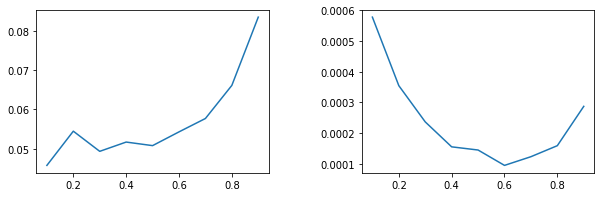

In [4]:
plt.figure(figsize=(10, 3))

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.subplot(1, 2, 1)
plt.plot(df_results['rate'], df_results['mean'])

plt.subplot(1, 2, 2)
plt.plot(df_results['rate'], df_results['variance'])

### CVの分割数を変えていく

In [5]:
results = []

for cv in range(2, 10):
    error_rates = []
    for i in range(100):
        model = LogisticRegression()
        kfold = KFold(n_splits=cv, shuffle=True)
        scores = cross_val_score(model, cancer.data, cancer.target, cv=kfold, scoring="accuracy")
        error_rates.append(np.mean(1 - scores))
    
    results.append([cv, np.mean(error_rates), np.var(error_rates)])
    
df_results = pd.DataFrame(results, columns=['cv', 'mean', 'variance'])
df_results

,cv,mean,variance
0,2,0.052777,0.000022
1,3,0.050474,0.000012
2,4,0.050073,0.000012
3,5,0.049911,0.000010
4,6,0.049159,0.000008
5,7,0.049108,0.000008
6,8,0.049210,0.000007
7,9,0.048968,0.000007


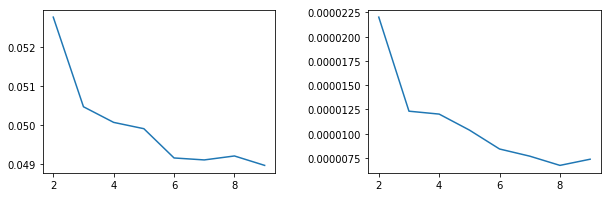

In [6]:
plt.figure(figsize=(10, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(1, 2, 1)
plt.plot(df_results['cv'], df_results['mean'])

plt.subplot(1, 2, 2)
plt.plot(df_results['cv'], df_results['variance'])

# 課題2
## 多項式近似で複数のデータセット間のバイアス、バリアンスを算出する

In [7]:
def f(x):
    e = np.random.normal(loc=0, scale=np.sqrt(0.01), size=len(x))
    return 0.5 + 0.4 * np.sin(2 * np.pi * x) + e

In [8]:
data_x = np.random.rand(11)
data_y = np.array([f(data_x) for i in range(100)])

results = []

for d in [1, 3, 6, 10]:
    predict = []
    for i in range(data_y.shape[0]):
        polynomial_features = PolynomialFeatures(degree=d)
        poly_x = polynomial_features.fit_transform(data_x.reshape(-1, 1))
        model = LinearRegression()
        model.fit(poly_x, data_y[i])
        predict.append(model.predict(poly_x))
    
    predict_mean = np.mean(predict, axis=0)
    bias = (predict_mean - data_y.mean(axis=0)) ** 2
    variance = np.var(predict, axis=0)
    results.append([d, bias.mean(), variance.mean()])

df_results = pd.DataFrame(results, columns=['dim', 'bias', 'variance'])
df_results

,dim,bias,variance
0,1,1.937584e-02,0.001779
1,3,3.162914e-04,0.004032
2,6,1.262126e-06,0.006860
3,10,7.859964e-21,0.010059


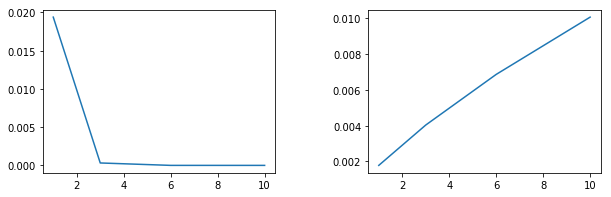

In [9]:
plt.figure(figsize=(10, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(1, 2, 1)
plt.plot(df_results['dim'], df_results['bias'])

plt.subplot(1, 2, 2)
plt.plot(df_results['dim'], df_results['variance'])

# 課題3
## ROC曲線を描き、AUCを算出

In [10]:
def fit_models(models, x, y):
    for model in models:
        model.fit(x, y)
    return models

def calc_auc(y, predict):
    fp_rate, tp_rate, thresholds = metrics.roc_curve(y, predict)
    print(f'thresholds {thresholds}')
    auc = metrics.auc(fp_rate, tp_rate)
    return fp_rate, tp_rate, auc

In [16]:
train_X, test_X, train_y, test_y = train_test_split(cancer.data, cancer.target, test_size=0.3)

models = [LogisticRegression(), SVC(kernel='linear')]
models = fit_models(models, train_X, train_y)

### ロジスティック回帰とSVM

thresholds [2 1 0]
thresholds [2 1 0]


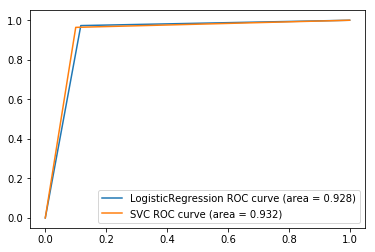

In [17]:
for model in models:
    predict = model.predict(test_X)
    fp_rate, tp_rate, auc = calc_auc(test_y, predict)
    name = model.__class__.__name__
    plt.plot(fp_rate, tp_rate, label=f'{name} ROC curve (area = {round(auc, 3)})')
    plt.legend()

### ロジスティック回帰で予測の閾値を変えてみる

thresholds [2 1 0]
thresholds [2 1 0]
thresholds [2 1 0]


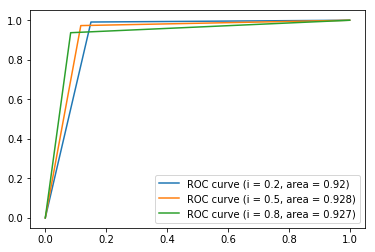

In [18]:
for i in range(2, 10, 3):
    predict = (models[0].predict_proba(test_X)[:, 1] > i * 0.1).astype(int)
    fp_rate, tp_rate, auc = calc_auc(test_y, predict)
    plt.plot(fp_rate, tp_rate, label=f'ROC curve (i = {round(i*0.1, 1)}, area = {round(auc, 3)})')
    plt.legend()

### ロジスティック回帰で確率をそのまま渡す

thresholds [9.99991666e-01 9.75544226e-01 9.75517273e-01 9.10168914e-01
 8.61821848e-01 7.52333683e-01 6.84544047e-01 6.03575492e-01
 4.25746344e-01 3.92259844e-01 8.21052781e-02 5.56228745e-02
 6.16367776e-34]


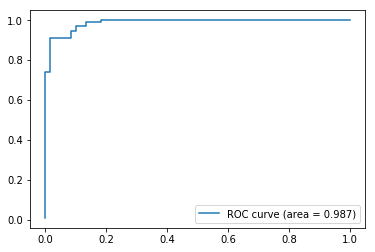

In [19]:
predict = models[0].predict_proba(test_X)[:, 1]
fp_rate, tp_rate, auc = calc_auc(test_y, predict)
plt.plot(fp_rate, tp_rate, label=f'ROC curve (area = {round(auc, 3)})')
plt.legend()